In [ ]:
# download the sample image
!wget --no-check-certificate \
    https://drive.google.com/uc?id=15ywep3yQV_hb5J1n4vVkS0nT5XdJhJ-B -O connectivity.png

--2024-10-30 11:43:40--  https://drive.google.com/uc?id=15ywep3yQV_hb5J1n4vVkS0nT5XdJhJ-B
Resolving drive.google.com (drive.google.com)... 173.194.210.102, 173.194.210.139, 173.194.210.101, ...
Connecting to drive.google.com (drive.google.com)|173.194.210.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=15ywep3yQV_hb5J1n4vVkS0nT5XdJhJ-B [following]
--2024-10-30 11:43:40--  https://drive.usercontent.google.com/download?id=15ywep3yQV_hb5J1n4vVkS0nT5XdJhJ-B
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2136 (2.1K) [image/png]
Saving to: ‘connectivity.png’

connectivity.png    100%[===================>]   2.09K  --.-KB/s    in 0s      

2024-10-30 11:43:42 (23.8 MB/s) - ‘connecti

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt

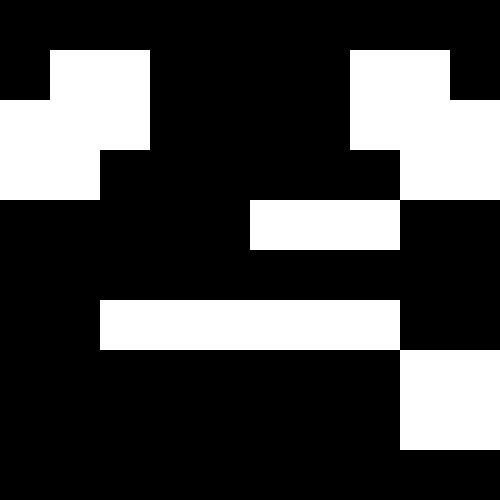

Image height= 500 px, and width= 500 px and data type: uint8


In [ ]:
# load and display the sample image
image = cv2.imread('connectivity.png', cv2.IMREAD_GRAYSCALE)
cv2_imshow(image)

height, width = image.shape
print("Image height=", height, "px, and width=", width, "px and data type:", image.dtype)

In this homework, your task is to implement the **two-pass algorithm** to label connected components in a binary image. The provided code includes a function that returns the output from OpenCV. You are expected to replace this OpenCV call with your own implementation. Additionally, I have included code to test and visualize the output. You should only implement the function below.

**Note:**Please test your implementation with various images.

In [ ]:
def two_pass_connected_components(image, connectivity=4):
  """
  Implement the two-pass algorithm for connected component extraction.

  This function takes a binary image and extracts all the connected components based on given connectivity.

  Parameters:
  -----------
  image : numpy.ndarray
      A binary (grayscale) image where connected components will be labeled.
      It should contain binary values (e.g., 0 for background and 1 for foreground).

  connectivity : int, optional, default=4
      Connectivity determines how neighbors are defined:
      - connectivity=4: Considers only the four directly adjacent neighbors (top, bottom, left, right).
      - connectivity=8: Considers all eight surrounding pixels.

  Returns:
  --------
  num_labels : int
      The total number of labels, including the background label (typically 0).

  labels : numpy.ndarray
      A labeled image where each connected component is marked with a unique integer label.
      The background is labeled as 0.
  """
  def find(x, parent):
    """
    Find the root of the set containing x with path compression.

    Parameters:
    -----------
    x : int
        The label whose root we want to find.

    parent : numpy.ndarray
        An array where each index points to its "parent" label in the union-find structure.
        If a label is its own parent, it is the root of that component.

    Returns:
    --------
    int
        The root label of the set containing x.
    """
    if parent[x] != x:
      parent[x] = find(parent[x], parent)
    return parent[x]



  def union(x, y, parent):
    """
    Perform union of the sets containing x and y.

    Parameters:
    -----------
    x : int
        The label of the first set to be united.

    y : int
        The label of the second set to be united.

    parent : numpy.ndarray
        An array representing the union-find structure, where each index points to its parent.
        This array will be updated to reflect the union operation.

    Returns:
    --------
    None
        This function modifies the parent array in place to merge the two sets.
    """
    temp_x = x
    temp_y = y

    while parent[temp_x] != temp_x:
      temp_x = parent[temp_x]
    while parent[temp_y] != temp_y:
      temp_y = parent[temp_y]

    if temp_x != temp_y:
      parent[temp_y] = temp_x


  def initialize(max_lab):
    """
    Initialize the label counter and parent array.

    Parameters:
    -----------
    max_lab : int
        The maximum number of labels that could be created (typically rows * cols / 2).

    Returns:
    --------
    label : int
        The initial label counter, starting from 1.

    parent_arr : numpy.ndarray
        An array of size max_lab, initialized so that each element points to itself,
        supporting the union-find structure for connected component labeling.
    """
    label = 0  # Start labeling from 1
    parent_arr = np.arange(max_lab, dtype=int)  # Each label initially points to 0
    return label, parent_arr

  max_row, max_col = image.shape
  max_lab = max_row * max_col // 2
  label, parent_arr = initialize(max_lab=max_lab)

  LB = np.zeros_like(image, dtype = int)
  for row in range(max_row):
    for col in range(max_col):
      if image[row, col] == 255:
        prior_neighbours = []

        if row > 0 and LB[row - 1, col] > 0: # top
          prior_neighbours.append(LB[row - 1, col])
        if col > 0 and LB[row, col - 1] > 0 : # left
          prior_neighbours.append(LB[row, col - 1])
        if connectivity == 8:
          if row > 0 and col > 0 and LB[row - 1, col - 1] > 0:
            prior_neighbours.append(LB[row - 1, col - 1]) # top left
          if row > 0 and col < max_col - 1 and LB[row - 1, col + 1] > 0: # top right
            prior_neighbours.append(LB[row - 1, col + 1])

        if prior_neighbours == []:
          LB[row, col] = label
          parent_arr[label] = label
          label += 1
        else:
          #take minimum of the labels of neighbours
          temp_label = min(prior_neighbours)
          LB[row, col] = temp_label
          for labels in prior_neighbours:
            union(temp_label, labels, parent_arr)

  # Pass 2 replaces Pass 1 labels with equivalance class labels
  for row in range(max_row):
    for col in range(max_col):
      if image[row, col] == 255:
        LB[row, col] = find(LB[row, col], parent_arr)

  unique_labels = np.unique(LB)
  label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}

  # Apply the new label mapping to both LB and parent_arr
  for old_label, new_label in label_mapping.items():
      parent_arr[old_label] = new_label  # Update parent array with new ordered labels

  for row in range(max_row):
      for col in range(max_col):
         if LB[row, col] > 0:
            LB[row, col] = label_mapping[LB[row, col]]

  num_labels = len(unique_labels)  # Number of unique labels
  return num_labels, LB

In [ ]:
num_labels_4, labels_4 = two_pass_connected_components(image)
output_image_4 = np.zeros((labels_4.shape[0], labels_4.shape[1], 3), dtype=np.uint8)

num_labels_8, labels_8 = two_pass_connected_components(image, connectivity=8)
output_image_8 = np.zeros((labels_8.shape[0], labels_8.shape[1], 3), dtype=np.uint8)

colors_4 = np.random.randint(0, 255, size=(num_labels_4, 3))
for label in range(1, num_labels_4):
    output_image_4[labels_4 == label] = colors_4[label]


colors_8 = np.random.randint(0, 255, size=(num_labels_8, 3))
for label in range(1, num_labels_8):
    output_image_8[labels_8 == label] = colors_8[label]

In [ ]:
print(num_labels_4)
print(num_labels_8)

6
4


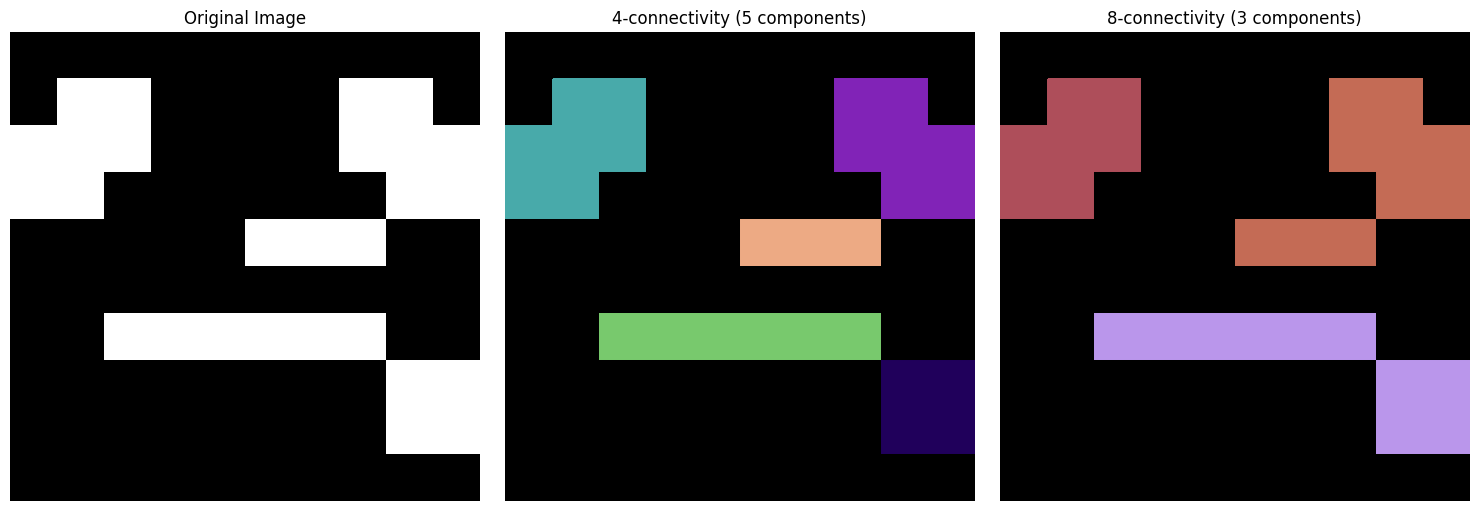

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(output_image_4, cmap='gray')
axes[1].set_title(f"4-connectivity ({num_labels_4 - 1} components)")
axes[1].axis('off')

axes[2].imshow(output_image_8, cmap='gray')
axes[2].set_title(f"8-connectivity ({num_labels_8 - 1} components)")
axes[2].axis('off')


plt.tight_layout()
plt.show()